In [1]:
import anndata
import os
import numpy as np
import scanpy as sc
import pandas as pd
import copy
import timeit
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import gc


### Load Data

In [2]:
canceradata = anndata.read_h5ad('canceradata.h5ad')

In [3]:
canceradata

AnnData object with n_obs × n_vars = 373058 × 33287
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset', 'cell.type'
    var: 'gene_symbols'

In [1]:
1+1

2

### Thresholding extremely low counts

In [4]:
#checking
bdata = copy.deepcopy(canceradata)
sc.pp.normalize_total(bdata,1e4)
sc.pp.log1p(bdata)
f = bdata.X
del bdata
gc.collect()

56448

In [5]:
f=f.todense()

In [6]:
f=f[f>0]
f=f.reshape(-1)

In [7]:
f.min()

0.091604725

In [8]:
f.shape

(1, 741331835)

In [9]:
ff = f[:,:f.shape[1]//1]

In [10]:
ff = np.array(ff)

In [11]:
ff = ff.reshape((-1))
ff.shape

(741331835,)

(array([3.52654126e+08, 2.55499426e+08, 1.05044738e+08, 1.98007400e+07,
        5.69383300e+06, 1.78281200e+06, 6.12891000e+05, 1.53688000e+05,
        4.92320000e+04, 4.03490000e+04]),
 array([0.09160472, 0.98864973, 1.88569474, 2.78273964, 3.67978477,
        4.57682991, 5.47387457, 6.3709197 , 7.26796484, 8.1650095 ,
        9.06205463]),
 <BarContainer object of 10 artists>)

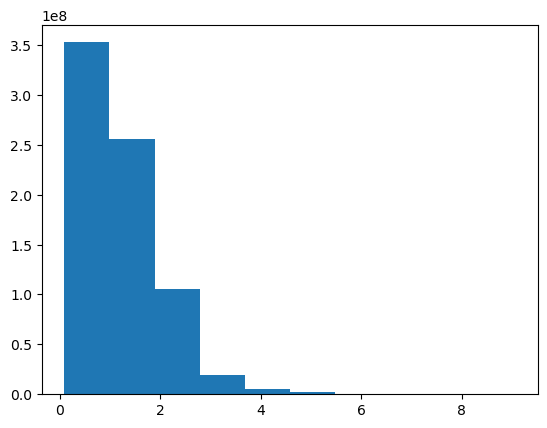

In [12]:
plt.hist(ff)

In [13]:
l=0
h=1
monomode = True
for i in range(7):
    thisbin = ((ff<h)*(ff>l)).sum()
    l+=1
    h+=1
    nextbin = ((ff<h)*(ff>l)).sum()
    if nextbin > thisbin:
        monomode = False
    print('thisbin:',thisbin,'nextbin:',nextbin)
        
print(monomode)

thisbin: 356581300 nextbin: 275490205
thisbin: 275490205 nextbin: 88621169
thisbin: 88621169 nextbin: 15107350
thisbin: 15107350 nextbin: 3972099
thisbin: 3972099 nextbin: 1151983
thisbin: 1151983 nextbin: 289170
thisbin: 289170 nextbin: 72028
True


In [14]:
library_sizes = canceradata.X.sum(axis=1)

In [15]:
canceradata.X.shape

(373058, 33287)

In [16]:
import timeit
s=timeit.default_timer()
if monomode:
    newmat = []
    for i in range(canceradata.X.shape[0]):
        row = canceradata.X[i]
        if i%10000 == 0:
            print(i)
        row[row <= library_sizes[i]/1000] = 0
        newmat.append(row.todense())
    newmat = np.concatenate(newmat)
end=s=timeit.default_timer()
print(str(end-s))

0


/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
0.0


In [17]:
from scipy.sparse import csr_matrix
cdata = anndata.AnnData(csr_matrix(newmat))
cdata.obs = canceradata.obs
cdata.var = canceradata.var


In [18]:
cdata.write('canceradata_thresholded_10.h5ad')

In [2]:
cdata = anndata.read_h5ad('canceradata_thresholded_10.h5ad')

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

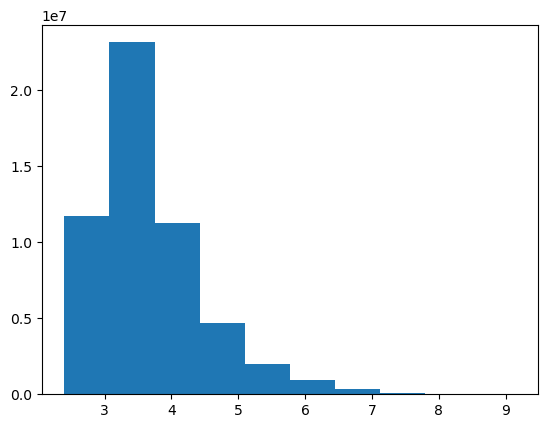

In [19]:
adata = copy.deepcopy(cdata)
sc.pp.normalize_total(adata,1e4)
sc.pp.log1p(adata)
f = adata.X
del adata
gc.collect()
f=f.todense()
f=f[f>0]
f=f.reshape(-1)
ff = f[:,:f.shape[1]//1]
ff = np.array(ff)
ff = ff.reshape((-1))
plt.hist(ff)
#plt.save('hist_after_thresholding.png',dpi=300)


In [20]:
del canceradata
gc.collect()

4335

In [21]:
canceradata = copy.deepcopy(cdata)

In [22]:
del cdata
gc.collect()

16

### Quality Control

In [122]:
canceradata = anndata.read_h5ad('canceradata_thresholded_10.h5ad')

In [123]:
canceradata

AnnData object with n_obs × n_vars = 373058 × 33287
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset', 'cell.type'
    var: 'gene_symbols'

In [124]:
#plt.hist((x>0).sum(axis=1))

In [125]:
# initial filtering
#sc.pp.filter_cells(canceradata, min_genes=200)
#sc.pp.filter_genes(canceradata, min_cells=3)

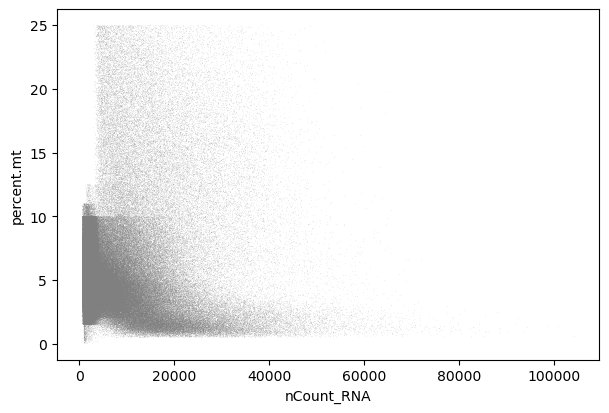

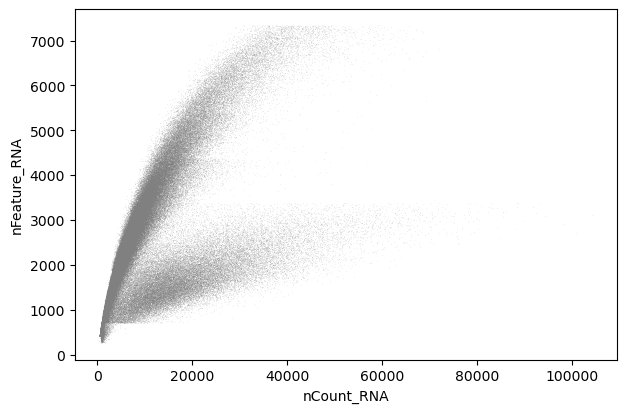

In [126]:
sc.pl.scatter(canceradata, x='nCount_RNA', y='percent.mt')
sc.pl.scatter(canceradata, x='nCount_RNA', y='nFeature_RNA')

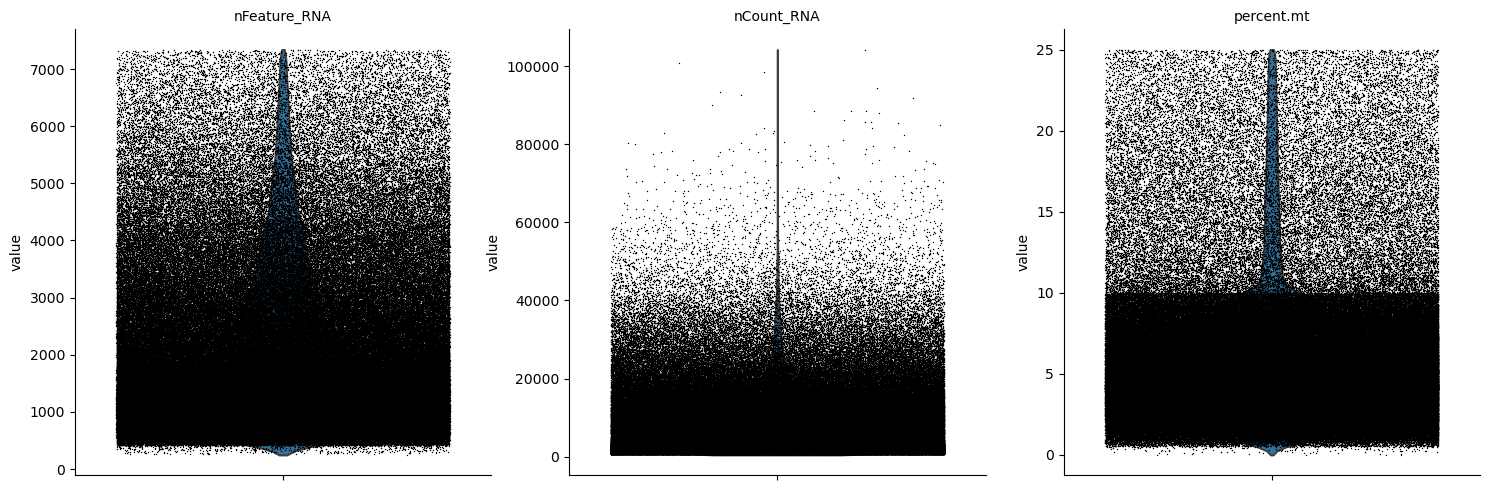

In [127]:
sc.pl.violin(canceradata, ['nFeature_RNA', 'nCount_RNA', 'percent.mt'],
             jitter=0.4, multi_panel=True)

In [128]:
canceradata = canceradata[canceradata.obs.nFeature_RNA < 6000, :]
canceradata = canceradata[canceradata.obs['percent.mt'] < 20, :]

(array([2.72855e+05, 6.04570e+04, 1.88930e+04, 4.98900e+03, 1.60100e+03,
        5.16000e+02, 1.80000e+02, 5.00000e+01, 1.60000e+01, 4.00000e+00]),
 array([   462. ,  10839.9,  21217.8,  31595.7,  41973.6,  52351.5,
         62729.4,  73107.3,  83485.2,  93863.1, 104241. ]),
 <BarContainer object of 10 artists>)

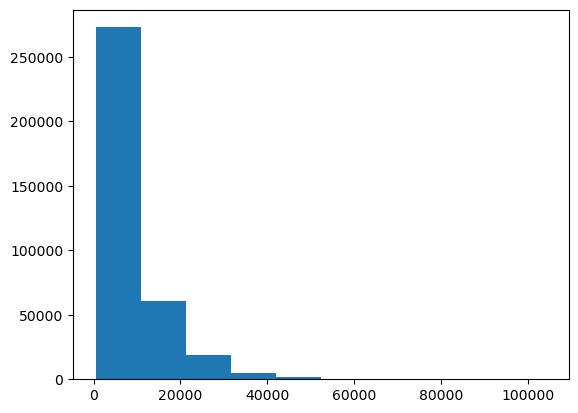

In [129]:
plt.hist(canceradata.obs.nCount_RNA)

In [130]:
canceradata = canceradata[canceradata.obs.nCount_RNA > 2000, :]

In [131]:
x = canceradata.X[-3:].todense()
(x[x>0] == 1).sum()

0

In [132]:
canceradata.X.sum(axis=1)

matrix([[ 7395.],
        [ 3056.],
        [ 4390.],
        ...,
        [ 8966.],
        [22007.],
        [13990.]], dtype=float32)

### Filter Sample with <1000 cells

In [133]:
sids = np.unique(canceradata.obs['sample.ID'])

In [139]:
 len(os.listdir('geneset'))

80

In [135]:
validsamples = 0
for sid in sids:
    adata = canceradata[canceradata.obs['sample.ID']==sid]
    if (adata.X.shape[0])>1000:
        sc.pp.normalize_total(adata,1e4)
        adata.write('sample_sc/'+sid+'.h5ad')
        validsamples+=1
print(validsamples)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


112


In [46]:
sids = np.unique(canceradata.obs['sample.ID'])

In [47]:
sc.pp.normalize_total(canceradata,1e4)

In [48]:
canceradata.X.sum(axis=1)

matrix([[10000.001],
        [10000.001],
        [10000.   ],
        ...,
        [ 9999.999],
        [10000.   ],
        [ 9999.999]], dtype=float32)

In [ ]:
1+1

In [ ]:
len(os.listdir('geneset'))

In [49]:
sc.tl.pca(canceradata)

In [50]:
sc.pp.neighbors(canceradata, n_neighbors=10, n_pcs=40)

In [51]:
sc.tl.umap(canceradata)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


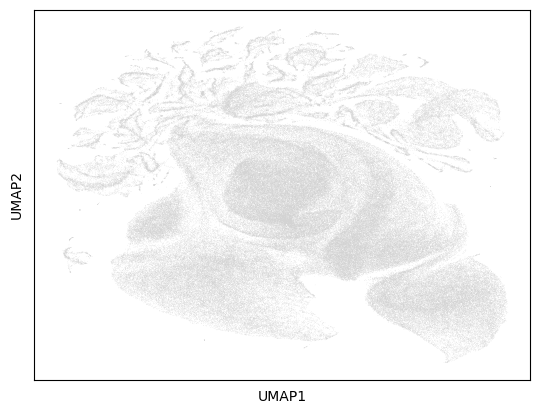

In [52]:
sc.pl.umap(canceradata)

In [53]:
canceradata.obs['cell.type']

CRC16_MUX8563_AAACGGGGTCGATTGT-1    Epithelial
CRC16_MUX8563_ACAGCCGGTCTCTTAT-1    Epithelial
CRC16_MUX8563_ACATACGGTTACGTCA-1    Epithelial
CRC16_MUX8563_ACGAGGACATCTGGTA-1    Epithelial
CRC16_MUX8563_ACTGATGAGTGGACGT-1    Epithelial
                                       ...    
KUL5_EXT129_TTTGTCACACAAGCCC-1         PlasmaB
KUL5_EXT129_TTTGTCAGTTAAGGGC-1         PlasmaB
KUL5_EXT129_TTTGTCAGTTGGACCC-1         PlasmaB
KUL5_EXT129_TTTGTCATCGGTTCGG-1         PlasmaB
KUL5_EXT129_TTTGTCATCTATCGCC-1         PlasmaB
Name: cell.type, Length: 259283, dtype: category
Categories (11, object): ['B', 'Endothelial', 'Entericglial', 'Epithelial', ..., 'Neutrophils', 'PlasmaB', 'T_NK', 'pDC']

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


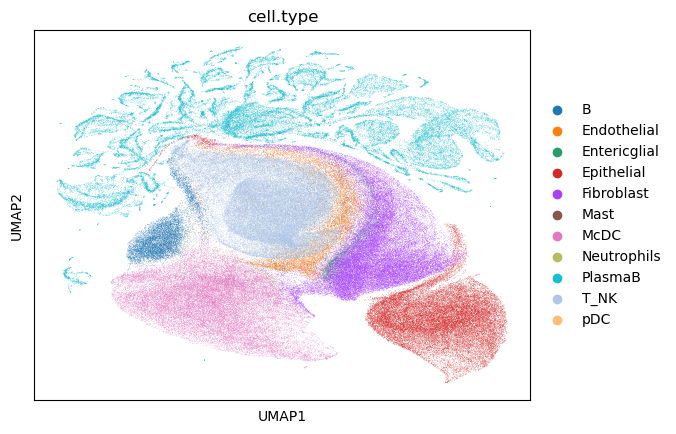

In [54]:
sc.pl.umap(canceradata,color='cell.type')

In [1]:
canceradata

NameError: name 'canceradata' is not defined

In [59]:
validsample=[]
for sid in sids:
    adata = canceradata[canceradata.obs['sample.ID']==sid]
    if (adata.X.shape[0])>1000:
        validsample.append(True)
    else:
        validsample.append(False)

In [82]:
bulkx = []
newsids = []
for i in range(len(sids)):
    sid = sids[i]
    if validsample[i]:
        adata = canceradata[canceradata.obs['sample.ID']==sid]
        bx = adata.X.todense()
        bx = bx.mean(axis=0)
        bulkx.append(bx)
        newsids.append(sid)
    
bulkx = np.concatenate(bulkx,axis=0)
bulkdata = anndata.AnnData(bulkx)
bulkdata.var = canceradata.var
bulkdata.obs['sampleid'] = list(newsids)
bulkdata.write('bulkcount.h5ad')

    

In [83]:
if 'highly_variable' in bulkdata.var:
    bulkdata.var.pop('highly_variable')

In [84]:
bulkdata.X.max()

2536.2844

In [87]:
sc.pp.log1p(bulkdata)

In [88]:
fig5a = ['APC','FBXW7','SOX9','ARID1A','RNF43','FAT1','BCL9L','TCF7L2','AXIN2','CTNNB1','ZNRF3','LRP5','DKK2','DKK3','DKK1','FZD10','APC2',
'NKD1','APCDD1','NOTUM','ZNRF3','FZD10','DKK3','RSPO3','RSPO4',
'APCDD1','NOTUM','NKD1','EPHB2','RNF43','AXIN2','ZNRF3','LGR5','WIF1',
'RSPO3','SFRP1','RSPO1','RSPO2','DKK2','DKK3','SFRP2','SFRP4']

fig5b = ['KRAS','BRAF','ERBB4','ERBB3','NRAS','ERBB2',
'ETV4','AREG','EREG','CRK','MAP2K4','FAS','JAK2','DUSP10','ETV5','DUSP4','EPHA4','MAX']

fig5c = ['SMAD4','ACVR2A','ACVR1B','TGFBR2','TGFBR1','SMAD2','SMAD3','TGFB1',
'CDH1','ACVR1B','ACVR2B','TGFBR2','PMEPA1','SMAD7',
'ACVR2A','PPM1A','SMAD2','SMAD4','SMAD1','RHOA','UBE2D3']

fig7a = ['SMARCA4','TEAD2','MSX2','TCF7','AXIN2','RNF43','ARID3A','TGFBI','FOXQ1','ASCL2','SOX4','CLDN2','CD44','STAT1','STAT3','ATOH8','GATA6','CDX2','EPHB2']

fig7b = ['RXRA','FOSL2','GSDMD','KLF4','VDR','ATF3','GSDMB','IL18','SMAD3','FSCN1','TFF2','ANXA1','AQP5','ANXA10','RELB','MUC17','REG4','MUC5AC','AHR','MSLN','IRF7','MDK','TACSTD2','S100P','PDX1','STAT6']

fig7d = ['MUC2','TFF3','REG4','MUC5AC','MDK','TACSTD2','ANXA1','TFF2','ANXA10','AQP5','MUC17','CDX2']


In [89]:
totalmarkers = np.unique( fig5a + fig5b + fig5c + fig7a + fig7b + fig7d )

In [90]:
#for i in newsids:
#    print((canceradata.obs['sample.ID'] == i).sum())

In [92]:
bdata = copy.deepcopy(bulkdata)

In [103]:
sc.pp.highly_variable_genes(bulkdata,n_top_genes=4000)

In [104]:
bulkdata.var['highly_variable'].sum()

4000

In [105]:
for g in totalmarkers:
    if g not in bulkdata.var['gene_symbols']:
        print(g)

In [106]:
c=0
for g in totalmarkers:
    if g not in bulkdata.var['gene_symbols'][bulkdata.var.highly_variable]:
        print(g)
        c+=1
        

ACVR1B
ACVR2A
ACVR2B
ANXA1
APC
APC2
ARID1A
ATF3
ATOH8
BCL9L
CD44
CRK
DKK2
DUSP10
DUSP4
EPHA4
ERBB2
ERBB4
ETV4
ETV5
FBXW7
FOXQ1
FZD10
GATA6
GSDMB
GSDMD
JAK2
KLF4
MAP2K4
MDK
MSX2
NRAS
PPM1A
RHOA
RSPO1
RSPO2
RSPO4
RXRA
SMAD1
SMAD2
SMAD3
SMAD4
SMAD7
SMARCA4
STAT1
STAT3
STAT6
TEAD2
TGFBI
TGFBR1
UBE2D3
VDR
ZNRF3


In [107]:
c

53

In [108]:
hvmask = []
for i in range(bulkdata.X.shape[1]):
    if (bulkdata.var.highly_variable[i]==True) or (bulkdata.var.index[i] in totalmarkers):
        hvmask.append(True)
    else:
        hvmask.append(False)
        
hvmask = np.array(hvmask)

In [109]:
hvmask.sum()

4053

In [110]:
canceradata = canceradata[:, hvmask]

In [111]:
canceradata

View of AnnData object with n_obs × n_vars = 259283 × 4053
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset', 'cell.type'
    var: 'gene_symbols', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors', 'umap', 'cell.type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [112]:
np.save('hvmask.npy',hvmask)

In [113]:
f=open('sids.txt','w')
for i in range(len(newsids)):
    sid = newsids[i]
    f.write(sid+'\n')
f.close()

In [119]:
adata.X.sum(axis=1)

matrix([[4634.6924],
        [3942.359 ],
        [6855.8755],
        ...,
        [9783.95  ],
        [6670.211 ],
        [9564.79  ]], dtype=float32)

In [121]:
canceradata.write('hv_thresholded_filtered_cdata.h5ad')

In [141]:
canceradata

View of AnnData object with n_obs × n_vars = 259283 × 33287
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset', 'cell.type'
    var: 'gene_symbols'

### Semi-profiling Performance Checking

In [57]:
import gc

In [54]:
### load ground truth

hvmask = np.load('hvmask.npy')
setmask = np.load('hvset.npy')

gts=[]
for i in range(len(sids)):
    sid = sids[i]
    adata = anndata.read_h5ad('sample_sc/' + sid + '.h5ad')
    gt = np.array(adata[:,hvmask].X.todense())
    gts.append(gt)
    print(i,end=', ')
    
del adata


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 

NameError: name 'gc' is not defined

In [58]:
gc.collect()

5959

In [62]:
reprefile = 'training_rec/init_representatives_4.txt' 
clusterfile = 'training_rec/init_cluster_labels_4.txt' 



f= open(reprefile,'r')
lines=f.readlines()
init_representatives=[]
for l in lines:
    init_representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
init_cluster_labels=[]
lines=f.readlines()
for l in lines:
    init_cluster_labels.append(int(l.strip().split()[0]))
f.close()

representatives = init_representatives
cluster_labels = init_cluster_labels

In [63]:
### load new semi results
t_start = timeit.default_timer()
semis=[]
pids=sids
for i in range(len(pids)-100):
    pid = pids[i]
    repre = representatives[cluster_labels[i]]
    reprepid = pids[repre]
    if reprepid==pid:
        semis.append(gts[i])
    else:
        xsem = np.load('semidata/fast'+ reprepid+'_to_'+pid+'.npy')
        semis.append(xsem)
    print(i,end=', ')

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'for loading semi')
### end of loading semi

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
10.599483245052397 for loading semi


In [96]:
xrep.max()

6464.9053

In [155]:
pid = 0

xsemi = semis[pid]
xgt = gts[pid]
xrep = gts[representatives[cluster_labels[pid]]]

xsemi = xsemi * (xsemi>20)

xm = np.concatenate([xrep,xgt,xsemi],axis=0)

#xm = xm * (xm>20)

xm = np.log1p(xm)

pcatool =  PCA(n_components=100)
xm=pcatool.fit_transform(xm)

#umap_reduc=umap.UMAP(min_dist=0.5,spread=1.0,negative_sample_rate=5 )
umap_reduc=umap.UMAP()
xm = umap_reduc.fit_transform(xm)



colors = []
for i in range(len(xrep)):
    colors.append('blue')
    
for i in range(len(xgt)):
    colors.append('yellow')
    
for i in range(len(xsemi)):
    colors.append('red')





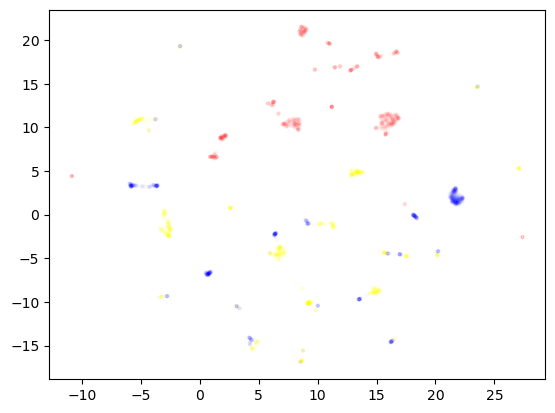

In [156]:
plt.scatter(x = xm[:,0], y = xm[:,1],c = colors,s=5,alpha=0.01)

In [133]:
for i in range(139):
    if canceradata.obs['sample.origin'][np.array(canceradata.obs['sample.ID'])==pids[i]][0] != 'Tumor':
        print(i)

17
18
20
21
23
24
25
28
29
31
32
33
34
35
37
39
40
42
43
44
47
48
51
52
53
54
55
56
57
60
61
62
65
68
69
70
73
74
75
76
77
78
79
84
88
89
92
93
96
97
98
99
101
103
105
107
109
111
114
131
132
133
134
136
137
138


In [137]:
cluster_labels[18]

0

In [140]:
canceradata.obs['sample.origin'][np.array(canceradata.obs['sample.ID'])==pids[18]][0]

'Normal'